In [9]:
import numpy as np
import matplotlib.pyplot as plt

class Tube: 
    
    def __init__(self, tag, sframe, eframe):
        self.tag = tag
        self.sframe = sframe 
        self.eframe = eframe 
        self.bbX = [] # bounding box x-axis 
        self.bbY = [] # bounding box y-axis
        self.bbH = [] # bounding box height
        self.bbW = [] # bounding box width
        
    def __len__(self):
        return len(self.bbX)
    
    def next_bounding_box(self, x, y, w, h):
        self.bbX.append(x)
        self.bbY.append(y)
        self.bbW.append(w)
        self.bbH.append(h)

    def get_bounding_box_at_frame(self, frame):
        i = frame - self.sframe
        return (self.bbX[i], self.bbY[i], self.bbW[i], self.bbH[i])
         
    def __iter__(self):
        self.iteridx = 0
        return self

    def __next__(self):
        if self.iteridx < len(self):
            frame = self.sframe + self.iteridx
            x, y, h, w = self.get_bounding_box_at_frame(frame)
            self.iteridx += 1
            return x, y, h, w, frame
        else:
            raise StopIteration
    
    def __str__(self):
        return self.tag
    
    def plot(self):
        plt.scatter(self.bbX, self.bbY, s=self.bbW, label=self.tag, marker='s')
        plt.plot(self.bbX, self.bbY, label='_nolegend_')
        

In [10]:
import pandas as pd

columns = [
    'frame', 
    'tag', 
    'x', 
    'y', 
    'w',
    'h',
]

with open('data/video-1.txt') as output:
    rawdata = [ line.strip().split(' ')[:6] for line in output.readlines() ]
    df = pd.DataFrame(rawdata, columns=columns)
    df = df.astype('int')

df.head(10)

,frame,tag,x,y,w,h
0,3,1,588,553,43,37
1,4,1,589,553,42,37
2,5,1,588,553,42,38
3,6,1,585,554,44,39
4,7,1,584,554,44,40
5,8,1,584,553,45,42
6,9,1,584,554,44,41
7,10,1,582,553,47,44
8,11,1,581,552,49,46
9,12,1,581,553,49,45


In [11]:
tubes = []

for tag in df.tag.unique():
    ob_df = df[df['tag'] == tag]
    if (len(ob_df) < 10): continue # remove shadows
    ob_df = ob_df.sort_values(by='frame')
    sframe = ob_df.frame.min()
    eframe = ob_df.frame.max()
    tube = Tube(tag, sframe, eframe)
    tubes.append(tube)
    for _, r in ob_df.iterrows():
        tube.next_bounding_box(r['x'], r['y'], r['w'], r['h'])

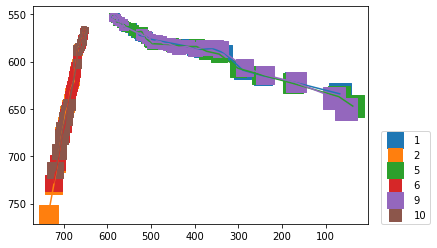

In [12]:
import matplotlib.pyplot as plt

def plot_tubes(tubes):
    plt.clf()
    for tube in tubes:
        tube.plot()
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.legend(loc=(1.04,0))
    plt.plot()
    
plot_tubes(tubes)

In [16]:
from itertools import permutations

class Overlapping:
    def __init__(self, start, end):
        self.sframe = start
        self.eframe = end
    def __str__(self):
        return 'OVL'

class Intersection:
    def __init__(self, frame):
        self.frame = frame
    def __str__(self):
        return 'INT'
        
class RelationsMap:
    def __init__(self, tubes):
        self.tubes = tubes
        self.relations = {}
        for Ta in tubes:
            self.relations[Ta.tag] = {}
            for Tb in tubes:
                self.relations[Ta.tag][Tb.tag] = None

    def compute(self):        
        for Ta, Tb in permutations(self.tubes, 2):
            if Ta == Tb: continue
            # we focus on tube A and check the
            # intersections with Tube B. 
            f_inter = None
            l_inter  = None
            for adata in Ta:
                for bdata in Tb:
                    frame = adata[4]
                    if self._frames_intersect(adata, bdata):
                        f_inter = frame if f_inter is None else f_inter
                        l_inter = frame
                    #d = np.linalg.norm([xa-xb, ya-yb]) 
                    #if d < 10:
                    #    f_inter = frame if f_inter is None else f_inter
                    #    l_inter = frame
            # In this case, there isn't interaction.
            if l_inter is None: continue
            # Following the paper recommendations, we 
            # set the interaction as overlapping if there 
            # are more than 5 intersecting frames. 
            self.relations[Ta.tag][Tb.tag] = Intersection(f_inter) \
                if l_inter - f_inter < 5 \
                else Overlapping(f_inter, l_inter)
              
    def _frames_intersect(self, adata, bdata):
        xa, ya, wa, ha, fa = adata
        xb, yb, wb, hb, fb = bdata
        l_ax, l_ay = xa, ya # Top-left point of square A
        r_ax, r_ay = xa + wa, ya + ha # Bottom-right point of square A
        l_bx, l_by = xb, yb # Top-left point of square B
        r_bx, r_by = xb + wb, yb + hb # Bottom-right point of square B
        # Check if one square has empty area.
        if l_ax == r_ax or l_ay == r_ay or l_bx == r_bx or l_by == r_by:
            return False
        # Check if one square stands above the other.
        if r_ay < l_by or r_by < l_ay:
            return False
        # Check if one square stands on the left of the other
        if r_ax < l_bx or r_bx < l_ax:
            return False
        # The squares overlap!
        return True
        
                
    def __str__(self):
        out = ""
        for k1 in self.relations.keys():
            out += f'[{k1}]:\t'
            for k2 in self.relations.keys():
                out += f'({k2}){self.relations[k1][k2]}\t'
            out += '\n'
        return out

In [17]:
# import numpy as np
# from matplotlib import pyplot as plt

# tube_1 = Tube('1', 10, 100)

# for x in np.linspace(10, 50, num=90):
#     y = 1/2 * 2 * (x**2)
#     tube_1.next_bounding_box(x, y, 100, 100)



# tube_2 = Tube('2', 0, 100//3)
# tube_2.posX = np.arange(0, 100, 3)
# tube_2.posY = np.flip(tube_1.posY)

# tube_3 = Tube('3', 20, 40)
# tube_3.posX = np.arange(20, 80, 3)
# tube_3.posY = np.full(len(tube_3.posX), 8000)

# tube_4 = Tube('4', 20, 40)
# tube_4.posX = np.arange(20, 80, 3)
# tube_4.posY = np.concatenate((np.full(10, 8000), np.arange(8000, 9000, step=100)))

# tube_1.plot()
# tube_2.plot()
# tube_3.plot()
# tube_4.plot()

In [18]:
rmap = RelationsMap(tubes)
rmap.compute()
print(rmap)

[1]:	(1)None	(2)None	(5)OVL	(6)None	(9)OVL	(10)None	
[2]:	(1)None	(2)None	(5)None	(6)OVL	(9)None	(10)OVL	
[5]:	(1)OVL	(2)None	(5)None	(6)None	(9)OVL	(10)None	
[6]:	(1)None	(2)OVL	(5)None	(6)None	(9)None	(10)OVL	
[9]:	(1)OVL	(2)None	(5)OVL	(6)None	(9)None	(10)None	
[10]:	(1)None	(2)OVL	(5)None	(6)OVL	(9)None	(10)None	

